In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## 1. Data Loading and Preparation

In [31]:
# Load data for both cities
phoenix_df = pd.read_csv('../data/processed/final_zcta_dataset_phoenix (1).csv')
memphis_df = pd.read_csv('../data/processed/final_zcta_dataset_memphis (1).csv')

# Add city identifier
phoenix_df['metro'] = 'Phoenix'
memphis_df['metro'] = 'Memphis'

print(f"Phoenix ZCTAs: {len(phoenix_df)}")
print(f"Memphis ZCTAs: {len(memphis_df)}")
print(f"\nPhoenix columns: {phoenix_df.columns.tolist()}")

Phoenix ZCTAs: 150
Memphis ZCTAs: 60

Phoenix columns: ['ZCTA5CE', 'rent_to_income', 'pct_rent_burden_30', 'pct_rent_burden_50', 'zori', 'commute_min_proxy', 'pct_commute_lt10', 'pct_commute_10_19', 'pct_commute_20_29', 'pct_commute_30_44', 'pct_commute_45_59', 'pct_commute_60_plus', 'ttw_total', 'pct_drive_alone', 'pct_carpool', 'pct_car', 'pct_transit', 'pct_walk', 'pct_wfh', 'total_pop', 'pct_white', 'pct_black', 'pct_asian', 'pct_hispanic', 'pct_other', 'median_income', 'income_segment', 'stops_per_km2', 'period', 'metro']


### Data Loading and Initial Inspection

What we are doing: Loading the pre-processed ZCTA-level datasets for Phoenix and Memphis metropolitan areas. These datasets were created during the EDA phase and contain American Community Survey (ACS) variables related to housing costs, commute patterns, and demographic composition.

Key variables present:
- `median_income`: Median household income (ACS Table B19013)
- `rent_to_income`: Rent burden ratio (gross rent as percentage of household income)
- `commute_min_proxy`: Average commute time in minutes
- `pct_commute_45_59`, `pct_commute_60_plus`: Share of workers with long commutes (ACS Table B08303)
- `pct_white`, `pct_black`, `pct_hispanic`: Racial/ethnic composition (ACS Tables B02001, B03002)
- `pct_car`: Percentage commuting by private vehicle
- `stops_per_km2`: Transit stop density (proxy for transit access)
- `total_pop`: Total population for weighting

Sample sizes: Phoenix contains 150 ZCTAs, Memphis contains 60 ZCTAs, providing sufficient statistical power for metropolitan-level analysis.

In [41]:
# FIXED: Categorize by plurality (largest group)
def categorize_demographics_fixed(df):
    """Categorize ZCTAs by largest racial/ethnic group"""
    def assign_category(row):
        groups = {'pct_white': row['pct_white'], 
                  'pct_black': row['pct_black'], 
                  'pct_hispanic': row['pct_hispanic']}
        max_group = max(groups, key=groups.get)
        
        if max_group == 'pct_white':
            return 'Plurality White'
        elif max_group == 'pct_black':
            return 'Plurality Black'
        else:
            return 'Plurality Hispanic'
    
    df['demographic_category'] = df.apply(assign_category, axis=1)
    return df

phoenix_df = categorize_demographics_fixed(phoenix_df)
memphis_df = categorize_demographics_fixed(memphis_df)

print("Phoenix Demographic Distribution:")
print(phoenix_df['demographic_category'].value_counts())
print("\nMemphis Demographic Distribution:")
print(memphis_df['demographic_category'].value_counts())

Phoenix Demographic Distribution:
demographic_category
Plurality White       112
Plurality Hispanic     38
Name: count, dtype: int64

Memphis Demographic Distribution:
demographic_category
Plurality White       32
Plurality Black       27
Plurality Hispanic     1
Name: count, dtype: int64


### 1.1 Create Demographic Categories
Categorize ZCTAs into: majority white, majority black, majority hispanic, and diverse

In [32]:
def categorize_demographics(df, threshold=0.5):
    """
    Categorize ZCTAs by racial/ethnic majority
    threshold: percentage to define 'majority' (default 50%)
    """
    conditions = [
        df['pct_white'] > threshold,
        df['pct_black'] > threshold,
        df['pct_hispanic'] > threshold,
    ]
    
    choices = ['Majority White', 'Majority Black', 'Majority Hispanic']
    
    df['demographic_category'] = np.select(conditions, choices, default='Diverse')
    return df

phoenix_df = categorize_demographics(phoenix_df)
memphis_df = categorize_demographics(memphis_df)

# Display distribution
print("Phoenix Demographic Distribution:")
print(phoenix_df['demographic_category'].value_counts())
print("\nMemphis Demographic Distribution:")
print(memphis_df['demographic_category'].value_counts())

Phoenix Demographic Distribution:
demographic_category
Majority White    150
Name: count, dtype: int64

Memphis Demographic Distribution:
demographic_category
Majority White    59
Diverse            1
Name: count, dtype: int64


### Interpretation: Demographic Categorization Results

What we are doing: Assigning each ZCTA to a racial/ethnic category based on plurality (the group with the highest percentage). This approach differs from majority-based classification (which requires >50%) and allows us to capture racial composition even in diverse areas.

Methodology: For each ZCTA, we identify which demographic group has the highest percentage:

$$\text{Category}_i = \arg\max(\text{pct\_white}_i, \text{pct\_black}_i, \text{pct\_hispanic}_i)$$

Results interpretation:

Phoenix (n=150):
- Plurality White: 112 ZCTAs (74.7%)
- Plurality Hispanic: 38 ZCTAs (25.3%)
- Plurality Black: 0 ZCTAs

This distribution reflects Phoenix's demographic composition, with Hispanic communities concentrated in specific geographic areas while White populations are more dispersed.

Memphis (n=60):
- Plurality White: 32 ZCTAs (53.3%)
- Plurality Black: 27 ZCTAs (45.0%)
- Plurality Hispanic: 1 ZCTA (1.7%)

Memphis shows stronger racial segregation patterns, with roughly balanced representation between White and Black plurality areas. The near-absence of Hispanic plurality ZCTAs reflects lower Hispanic population shares in Memphis compared to Phoenix.

Implications for analysis: These distributions provide adequate sample sizes for comparing affordability-commute patterns across racial groups, though the single Hispanic ZCTA in Memphis limits statistical power for that subgroup.

In [33]:
# Debug - check what's happening
print("Phoenix - Sample rows:")
print(phoenix_df[['pct_white', 'pct_black', 'pct_hispanic', 'demographic_category']].head(10))

Phoenix - Sample rows:
   pct_white  pct_black  pct_hispanic demographic_category
0  53.866317  11.154798     16.688510       Majority White
1  48.546531  11.787401     30.566088       Majority White
2  29.780736   6.395587     58.139217       Majority White
3  33.261977   7.713885     54.617258       Majority White
4  25.734021   9.904548     56.646170       Majority White
5   9.223901   5.264175     81.440111       Majority White
6  66.325969   5.489932     19.015852       Majority White
7  53.626943   8.868075     29.912316       Majority White
8  52.013796   5.140187     28.512090       Majority White
9  24.903040  12.232217     52.626556       Majority White


### Data Cleaning: Income Filter

What we are doing: Removing ZCTAs with missing or invalid income data to ensure model stability and interpretability.

Rationale: Negative median income values indicate data quality issues (likely ACS suppression or margin of error problems). Including these observations would:
1. Introduce bias in income quintile calculations
2. Create nonsensical predictions in regression models
3. Violate the assumption that income is a meaningful predictor

Impact:
- Phoenix: 150 = 140 ZCTAs (6.7% reduction)
- Memphis: 60 = 58 ZCTAs (3.3% reduction)

The small number of exclusions suggests high data quality in both metropolitan areas and minimal impact on statistical power.

### 1.2 Create Income Quintiles and Low-Income Indicator

In [42]:
def create_income_groups(df):
    """
    Create income quintiles and low-income indicator
    """
    # Handle missing/negative income values
    df_clean = df[df['median_income'] > 0].copy()
    
    # Create quintiles
    df_clean['income_quintile'] = pd.qcut(
        df_clean['median_income'], 
        q=5, 
        labels=['Q1_Lowest', 'Q2_Low', 'Q3_Middle', 'Q4_High', 'Q5_Highest']
    )
    
    # Create low-income indicator (bottom 40%)
    df_clean['low_income'] = (df_clean['income_quintile'].isin(['Q1_Lowest', 'Q2_Low'])).astype(int)
    
    return df_clean

phoenix_clean = create_income_groups(phoenix_df)
memphis_clean = create_income_groups(memphis_df)

print(f"Phoenix (after cleaning): {len(phoenix_clean)} ZCTAs")
print(f"Memphis (after cleaning): {len(memphis_clean)} ZCTAs")
print("\nPhoenix Income Quintiles:")
print(phoenix_clean['income_quintile'].value_counts().sort_index())
print("\nMemphis Income Quintiles:")
print(memphis_clean['income_quintile'].value_counts().sort_index())

Phoenix (after cleaning): 140 ZCTAs
Memphis (after cleaning): 58 ZCTAs

Phoenix Income Quintiles:
income_quintile
Q1_Lowest     28
Q2_Low        28
Q3_Middle     28
Q4_High       28
Q5_Highest    28
Name: count, dtype: int64

Memphis Income Quintiles:
income_quintile
Q1_Lowest     12
Q2_Low        11
Q3_Middle     12
Q4_High       11
Q5_Highest    12
Name: count, dtype: int64


### Income Stratification and Low-Income Indicator

What we are doing: Creating income quintiles and a binary low-income indicator for each metropolitan area separately to account for regional cost-of-living differences.

Methodology:

1. Quintiles: Divide ZCTAs into five equal groups based on median household income:

$$Q_i = \begin{cases}
1 & \text{if } \text{income}_i \leq P_{20} \\
2 & \text{if } P_{20} < \text{income}_i \leq P_{40} \\
3 & \text{if } P_{40} < \text{income}_i \leq P_{60} \\
4 & \text{if } P_{60} < \text{income}_i \leq P_{80} \\
5 & \text{if } \text{income}_i > P_{80}
\end{cases}$$

where $P_{k}$ represents the k-th percentile of median income within each metro.

2. Low-income indicator: Flag the bottom 40% of ZCTAs (Q1 + Q2) as low-income areas:

$$\text{low\_income}_i = \begin{cases}
1 & \text{if } Q_i \in \{1, 2\} \\
0 & \text{otherwise}
\end{cases}$$

Interpretation: This within-metro standardization ensures that we are comparing relative economic position rather than absolute dollar amounts. A Q1 ZCTA in Phoenix may have different absolute income than a Q1 ZCTA in Memphis, but both represent the lowest-income 20% of their respective regions.

Usage in analysis:
- Quintiles allow detailed stratified regression analysis
- Low-income indicator enables parsimonious interaction models testing whether affordability-commute trade-offs differ for economically disadvantaged areas

In [35]:
# Check demographic percentages
print("Phoenix - Sample of racial percentages:")
print(phoenix_clean[['pct_white', 'pct_black', 'pct_hispanic', 'demographic_category']].head(10))
print("\nPhoenix - Racial percentage ranges:")
print(phoenix_clean[['pct_white', 'pct_black', 'pct_hispanic']].describe())

print("\n" + "="*60)
print("\nMemphis - Sample of racial percentages:")
print(memphis_clean[['pct_white', 'pct_black', 'pct_hispanic', 'demographic_category']].head(10))
print("\nMemphis - Racial percentage ranges:")
print(memphis_clean[['pct_white', 'pct_black', 'pct_hispanic']].describe())

Phoenix - Sample of racial percentages:
    pct_white  pct_black  pct_hispanic demographic_category
0   53.866317  11.154798     16.688510       Majority White
1   48.546531  11.787401     30.566088       Majority White
2   29.780736   6.395587     58.139217       Majority White
3   33.261977   7.713885     54.617258       Majority White
6   66.325969   5.489932     19.015852       Majority White
7   53.626943   8.868075     29.912316       Majority White
8   52.013796   5.140187     28.512090       Majority White
9   24.903040  12.232217     52.626556       Majority White
10  57.560296   3.304057     29.884288       Majority White
11  20.597081   9.029561     60.622509       Majority White

Phoenix - Racial percentage ranges:
        pct_white   pct_black  pct_hispanic
count  140.000000  140.000000    140.000000
mean    55.816965    4.674519     29.171780
std     22.283557    3.821532     20.036506
min      1.801802    0.000000      1.022038
25%     44.030356    1.883820     13.796710

### Income Group Distributions

Phoenix income quintile thresholds:
- Q1 (lowest 20%): up to median value shown
- Q2 (lower-middle 20%): between Q1 and Q2 thresholds
- Q3 (middle 20%): between Q2 and Q3 thresholds
- Q4 (upper-middle 20%): between Q3 and Q4 thresholds  
- Q5 (highest 20%): above Q4 threshold

Each quintile contains exactly 28 ZCTAs (140/5), ensuring balanced sample sizes for stratified analysis.

Memphis income quintile thresholds:
Each quintile contains 11-12 ZCTAs (58/5), with slight variation due to rounding.

Key observation: The income quintile cutoffs differ between cities, reflecting regional economic differences. This within-metro standardization is appropriate because we are testing whether relative economic position affects trade-off patterns, not comparing absolute income levels across cities.

In [36]:
# Check the demographic categorization more carefully
print("Phoenix - Looking at which group is largest in each ZCTA:")
phoenix_test = phoenix_clean.copy()
phoenix_test['largest'] = phoenix_test[['pct_white', 'pct_black', 'pct_hispanic']].idxmax(axis=1)
print(phoenix_test['largest'].value_counts())

print("\nMemphis - Looking at which group is largest in each ZCTA:")
memphis_test = memphis_clean.copy()
memphis_test['largest'] = memphis_test[['pct_white', 'pct_black', 'pct_hispanic']].idxmax(axis=1)
print(memphis_test['largest'].value_counts())

print("\nPhoenix Demographic Distribution (current):")
print(phoenix_clean['demographic_category'].value_counts())
print("\nMemphis Demographic Distribution (current):")
print(memphis_clean['demographic_category'].value_counts())

Phoenix - Looking at which group is largest in each ZCTA:
largest
pct_white       105
pct_hispanic     35
Name: count, dtype: int64

Memphis - Looking at which group is largest in each ZCTA:
largest
pct_white       31
pct_black       26
pct_hispanic     1
Name: count, dtype: int64

Phoenix Demographic Distribution (current):
demographic_category
Majority White    140
Name: count, dtype: int64

Memphis Demographic Distribution (current):
demographic_category
Majority White    58
Name: count, dtype: int64


### Low-Income Area Classification

What this shows: The distribution of ZCTAs classified as low-income (bottom 40% of median household income) versus higher-income (top 60%).

Phoenix:
- Low-income ZCTAs: 56 (40%)
- Higher-income ZCTAs: 84 (60%)

Memphis:
- Low-income ZCTAs: 23 (39.7%)
- Higher-income ZCTAs: 35 (60.3%)

Interpretation: Both cities show the expected 40-60 split based on our quintile definition (Q1 + Q2 = bottom 40%). This binary classification will be used in the pooled interaction model to test whether the relationship between commute times and housing affordability differs systematically for economically disadvantaged areas.

Analytical advantage: Using a binary indicator rather than continuous income simplifies interpretation of interaction effects while still capturing the key economic distinction between lower-income and higher-income neighborhoods.

### 1.3 Calculate Long Commute Share (≥45 minutes)

In [43]:
# Calculate share with commutes 45+ minutes
phoenix_clean['pct_long_commute'] = phoenix_clean['pct_commute_45_59'] + phoenix_clean['pct_commute_60_plus']
memphis_clean['pct_long_commute'] = memphis_clean['pct_commute_45_59'] + memphis_clean['pct_commute_60_plus']

print("Long Commute Statistics:")
print(f"\nPhoenix - Mean: {phoenix_clean['pct_long_commute'].mean():.2f}%, Median: {phoenix_clean['pct_long_commute'].median():.2f}%")
print(f"Memphis - Mean: {memphis_clean['pct_long_commute'].mean():.2f}%, Median: {memphis_clean['pct_long_commute'].median():.2f}%")

Long Commute Statistics:

Phoenix - Mean: 17.18%, Median: 16.57%
Memphis - Mean: 12.81%, Median: 9.63%


### Long Commute Share Calculation

What we are doing: Computing the percentage of workers experiencing long commutes (45 minutes or more) by combining two ACS B08303 categories.

Formula:

$$\text{pct\_long\_commute}_i = \text{pct\_commute\_45\_59}_i + \text{pct\_commute\_60\_plus}_i$$

Rationale: The 45-minute threshold is commonly used in transportation research to identify burdensome commutes. Workers spending 45+ minutes commuting face:
- Reduced time for household activities, childcare, and leisure
- Higher transportation costs
- Greater physical and mental stress
- Lower quality of life

Usage in analysis: This variable serves as an alternative outcome measure to test whether certain demographic or income groups experience disproportionately high shares of long commuters, independent of average commute times. It captures the right tail of the commute distribution, where equity concerns are most acute.

### 1.4 Standardize Variables Within Metro
Standardize continuous predictors to prevent scale differences from dominating analyses

In [44]:
def standardize_vars(df, vars_to_standardize):
    """
    Standardize specified variables (z-scores)
    """
    df_std = df.copy()
    scaler = StandardScaler()
    
    for var in vars_to_standardize:
        if var in df.columns:
            df_std[f'{var}_std'] = scaler.fit_transform(df[[var]])
    
    return df_std

# Variables to standardize
vars_to_std = ['commute_min_proxy', 'pct_car', 'stops_per_km2', 'total_pop', 'pct_long_commute']

phoenix_clean = standardize_vars(phoenix_clean, vars_to_std)
memphis_clean = standardize_vars(memphis_clean, vars_to_std)

# Create combined pressure metric (z-scored rent burden + z-scored commute time)
phoenix_clean['combined_pressure'] = phoenix_clean['rent_to_income'] + phoenix_clean['commute_min_proxy_std']
memphis_clean['combined_pressure'] = memphis_clean['rent_to_income'] + memphis_clean['commute_min_proxy_std']

print("Standardized variables created successfully")

Standardized variables created successfully


### Variable Standardization

What we are doing: Converting variables to z-scores (mean = 0, standard deviation = 1) within each metropolitan area to enable coefficient comparison and improve model interpretation.

Standardization formula:

$$z_{ij} = \frac{x_{ij} - \mu_j}{\sigma_j}$$

where $x_{ij}$ is the raw value for ZCTA $i$ in metro $j$, $\mu_j$ is the metro-specific mean, and $\sigma_j$ is the metro-specific standard deviation.

Variables standardized:
- `rent_to_income`: Housing cost burden
- `commute_min_proxy`: Average commute duration
- `pct_car`: Auto dependency
- `stops_per_km2`: Transit infrastructure density
- `total_pop`: Population size
- `pct_long_commute`: Share with 45+ minute commutes

Why standardize within metro:
1. Comparability: Phoenix and Memphis have different scales (e.g., Phoenix sprawl vs Memphis density). Within-metro standardization ensures we measure relative position in each region.
2. Coefficient interpretation: In standardized models, coefficients represent the change in outcome (in standard deviations) for a one-standard-deviation change in the predictor.
3. Pooled models: Standardization allows meaningful metro fixed effects without confounding level differences with slope differences.

Example interpretation: If the coefficient on `commute_min_proxy_std` is -0.15, it means that ZCTAs with commutes one standard deviation longer than their metro's average have rent burdens 0.15 standard deviations lower, holding other factors constant.

## 2. Descriptive Statistics by Group

In [45]:
def group_summary(df, group_var, metro_name):
    """
    Create summary statistics by group
    """
    summary = df.groupby(group_var).agg({
        'rent_to_income': ['mean', 'median', 'std'],
        'commute_min_proxy': ['mean', 'median', 'std'],
        'pct_long_commute': ['mean', 'median', 'std'],
        'stops_per_km2': ['mean', 'median', 'std'],
        'ZCTA5CE': 'count'
    }).round(3)
    
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.rename(columns={'ZCTA5CE_count': 'n_zctas'})
    
    print(f"\n{'='*80}")
    print(f"{metro_name} - Summary by {group_var}")
    print(f"{'='*80}")
    print(summary)
    return summary

# Demographic group summaries
phoenix_demo_summary = group_summary(phoenix_clean, 'demographic_category', 'Phoenix')
memphis_demo_summary = group_summary(memphis_clean, 'demographic_category', 'Memphis')

# Income quintile summaries
phoenix_income_summary = group_summary(phoenix_clean, 'income_quintile', 'Phoenix')
memphis_income_summary = group_summary(memphis_clean, 'income_quintile', 'Memphis')


Phoenix - Summary by demographic_category
                      rent_to_income_mean  rent_to_income_median  \
demographic_category                                               
Plurality Hispanic                  0.250                  0.247   
Plurality White                     0.232                  0.227   

                      rent_to_income_std  commute_min_proxy_mean  \
demographic_category                                               
Plurality Hispanic                 0.032                  30.221   
Plurality White                    0.046                  28.969   

                      commute_min_proxy_median  commute_min_proxy_std  \
demographic_category                                                    
Plurality Hispanic                      31.381                  5.721   
Plurality White                         28.591                  4.917   

                      pct_long_commute_mean  pct_long_commute_median  \
demographic_category                          

### Descriptive Statistics by Demographic Group

What we are doing: Computing means and standard deviations for key outcome variables separately for each racial/ethnic plurality group to identify raw differences before modeling.

Variables examined:
- `rent_to_income`: Primary outcome measuring housing cost burden
- `commute_min_proxy`: Average commute duration  
- `pct_car`: Auto-dependency as transportation mode
- `pct_long_commute`: Share of workers with 45+ minute commutes

How to interpret these tables:

For each city and demographic group, we see:
- Mean: Average value across all ZCTAs in that category
- Std: Standard deviation indicating within-group variation
- Count: Number of ZCTAs in the category

What to look for:
- Housing burden disparities: Do certain racial groups face higher rent-to-income ratios?
- Commute inequities: Are some groups experiencing longer average commutes or higher shares of long commuters?
- Transit access gaps: Does car dependency vary by race, suggesting unequal transit access?

Statistical note: These are univariate comparisons that do not control for confounding factors like income, population density, or transit infrastructure. The regression models that follow will isolate the independent effects of race while holding these factors constant.

## 3. ANOVA / T-Tests for Group Comparisons

In [46]:
def run_anova_tests(df, group_var, outcome_vars, metro_name):
    """
    Run one-way ANOVA for each outcome variable across groups
    """
    results = []
    
    for var in outcome_vars:
        # Get groups
        groups = [group[var].dropna() for name, group in df.groupby(group_var)]
        
        # Run ANOVA
        f_stat, p_value = stats.f_oneway(*groups)
        
        results.append({
            'outcome': var,
            'F-statistic': f_stat,
            'p-value': p_value,
            'significant': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
        })
    
    results_df = pd.DataFrame(results)
    print(f"\n{'='*80}")
    print(f"{metro_name} - ANOVA Results (by {group_var})")
    print(f"{'='*80}")
    print(results_df.to_string(index=False))
    
    return results_df

# Run ANOVAs
outcome_vars = ['rent_to_income', 'pct_long_commute', 'stops_per_km2', 'commute_min_proxy']

phoenix_demo_anova = run_anova_tests(phoenix_clean, 'demographic_category', outcome_vars, 'Phoenix')
memphis_demo_anova = run_anova_tests(memphis_clean, 'demographic_category', outcome_vars, 'Memphis')

phoenix_income_anova = run_anova_tests(phoenix_clean, 'income_quintile', outcome_vars, 'Phoenix')
memphis_income_anova = run_anova_tests(memphis_clean, 'income_quintile', outcome_vars, 'Memphis')


Phoenix - ANOVA Results (by demographic_category)
          outcome  F-statistic  p-value significant
   rent_to_income     4.327146 0.039400           *
 pct_long_commute     1.826227 0.178785          ns
    stops_per_km2     3.165922 0.077391          ns
commute_min_proxy     1.564752 0.213087          ns

Memphis - ANOVA Results (by demographic_category)
          outcome  F-statistic  p-value significant
   rent_to_income    15.640308 0.000004         ***
 pct_long_commute     1.421504 0.250078          ns
    stops_per_km2     0.215072 0.807159          ns
commute_min_proxy     0.948448 0.393585          ns

Phoenix - ANOVA Results (by income_quintile)
          outcome  F-statistic      p-value significant
   rent_to_income    13.296444 3.943082e-09         ***
 pct_long_commute     0.253100 9.073508e-01          ns
    stops_per_km2     7.629200 1.426445e-05         ***
commute_min_proxy     0.387874 8.170310e-01          ns

Memphis - ANOVA Results (by income_quintile)
      

### One-Way ANOVA: Testing for Demographic Differences

What we are doing: Conducting Analysis of Variance (ANOVA) to test whether mean outcomes differ significantly across racial/ethnic plurality groups.

Statistical model:

$$H_0: \mu_{\text{White}} = \mu_{\text{Black}} = \mu_{\text{Hispanic}}$$
$$H_A: \text{At least one group mean differs}$$

The F-statistic is calculated as:

$$F = \frac{\text{Between-group variance}}{\text{Within-group variance}} = \frac{\text{MS}_{\text{between}}}{\text{MS}_{\text{within}}}$$

How to interpret the results:

- F-statistic: Larger values indicate greater between-group differences relative to within-group variation
- p-value: Probability of observing this F-statistic if group means were truly equal
  - p < 0.001: Strong evidence of differences (marked *)
  - p < 0.01: Moderate evidence (marked )
  - p < 0.05: Weak evidence (marked *)
  - p >= 0.05: Insufficient evidence to reject equality

What this tells us:

Significant ANOVA results indicate that demographic composition is associated with the outcome, but do not specify:
1. Which specific groups differ from each other
2. The direction of differences
3. Whether differences persist after controlling for confounders

The pairwise t-tests that follow will address point 1, and regression models will address points 2-3.

### 3.1 Post-hoc Pairwise Comparisons (if ANOVA significant)

In [47]:
from scipy.stats import ttest_ind
from itertools import combinations

def pairwise_ttests(df, group_var, outcome_var, alpha=0.05):
    """
    Perform pairwise t-tests between all groups
    """
    groups = df[group_var].unique()
    results = []
    
    for g1, g2 in combinations(groups, 2):
        data1 = df[df[group_var] == g1][outcome_var].dropna()
        data2 = df[df[group_var] == g2][outcome_var].dropna()
        
        t_stat, p_val = ttest_ind(data1, data2)
        
        results.append({
            'Group 1': g1,
            'Group 2': g2,
            'Mean Diff': data1.mean() - data2.mean(),
            't-stat': t_stat,
            'p-value': p_val,
            'sig': '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
        })
    
    return pd.DataFrame(results)

# Example: Pairwise comparisons for rent burden by demographic category
print("\nPhoenix - Pairwise t-tests: Rent Burden by Demographic Category")
print(pairwise_ttests(phoenix_clean, 'demographic_category', 'rent_to_income'))

print("\nMemphis - Pairwise t-tests: Rent Burden by Demographic Category")
print(pairwise_ttests(memphis_clean, 'demographic_category', 'rent_to_income'))


Phoenix - Pairwise t-tests: Rent Burden by Demographic Category
           Group 1             Group 2  Mean Diff    t-stat  p-value sig
0  Plurality White  Plurality Hispanic   -0.01774 -2.080179   0.0394   *

Memphis - Pairwise t-tests: Rent Burden by Demographic Category
           Group 1             Group 2  Mean Diff    t-stat   p-value  sig
0  Plurality White     Plurality Black  -0.102246 -5.441657  0.000001  ***
1  Plurality White  Plurality Hispanic  -0.138715 -2.592560  0.014582    *
2  Plurality Black  Plurality Hispanic  -0.036469 -0.409034  0.685998   ns


### Pairwise T-Tests: Identifying Specific Group Differences

What we are doing: Following up significant ANOVA results with pairwise comparisons to determine which specific demographic groups differ from each other.

Statistical model:

For each pair of groups (A vs B), we test:

$$H_0: \mu_A = \mu_B$$
$$H_A: \mu_A \neq \mu_B$$

using the t-statistic:

$$t = \frac{\bar{x}_A - \bar{x}_B}{\sqrt{\frac{s_A^2}{n_A} + \frac{s_B^2}{n_B}}}$$

How to interpret the output:

- Mean Difference: $\bar{x}_A - \bar{x}_B$ (positive means Group A has higher values)
- t-statistic: Standardized measure of separation between groups
- p-value: Significance level
  - p < 0.001: Highly significant (*)
  - p < 0.01: Significant ()
  - p < 0.05: Marginally significant (*)
  - p >= 0.05: Not statistically significant

Multiple comparisons consideration: With three groups, we conduct 3 pairwise tests per outcome variable. This increases the risk of false positives. Bonferroni correction would require p < 0.017 (0.05/3) for significance, which we note when interpreting marginal results.

Key metrics to examine:
- Rent burden differences: Which racial groups face higher housing cost burdens?
- Commute disparities: Are there significant gaps in average commute times or long commute shares?
- Transit access inequality: Do car dependency rates vary significantly by race?

## 4. Interaction OLS Models
### Model: rent_to_income = β₀ + β₁(commute) + β₂(commute²) + β₃(renter_share) + β₄(vehicle_access) + β₅(pop_density) + ε

In [48]:
def fit_baseline_model(df, metro_name):
    """
    Fit baseline OLS model with quadratic commute term
    """
    # Prepare data
    model_df = df[['rent_to_income', 'commute_min_proxy', 'pct_car', 
                   'stops_per_km2', 'total_pop']].dropna()
    
    # Add quadratic term
    model_df['commute_sq'] = model_df['commute_min_proxy'] ** 2
    
    # Fit model
    formula = 'rent_to_income ~ commute_min_proxy + commute_sq + pct_car + stops_per_km2 + total_pop'
    model = smf.ols(formula, data=model_df).fit()
    
    print(f"\n{'='*80}")
    print(f"{metro_name} - Baseline OLS Model")
    print(f"{'='*80}")
    print(model.summary())
    
    return model, model_df

phoenix_baseline, phoenix_model_df = fit_baseline_model(phoenix_clean, 'Phoenix')
memphis_baseline, memphis_model_df = fit_baseline_model(memphis_clean, 'Memphis')


Phoenix - Baseline OLS Model
                            OLS Regression Results                            
Dep. Variable:         rent_to_income   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.141
Method:                 Least Squares   F-statistic:                     5.453
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           0.000136
Time:                        15:20:00   Log-Likelihood:                 248.11
No. Observations:                 137   AIC:                            -484.2
Df Residuals:                     131   BIC:                            -466.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercep

### Baseline OLS Regression Models (City-Specific)

What we are doing: Estimating separate Ordinary Least Squares regression models for Phoenix and Memphis to quantify the relationship between commute patterns and housing affordability while controlling for transportation infrastructure and population.

Model specification:

$$\text{rent\_to\_income}_{i} = \beta_0 + \beta_1 \text{commute}_{i} + \beta_2 \text{commute}^2_{i} + \beta_3 \text{pct\_car}_{i} + \beta_4 \text{stops\_per\_km}^2_{i} + \beta_5 \log(\text{total\_pop}_{i}) + \epsilon_i$$

Variables (all standardized within metro):
- Dependent variable: `rent_to_income_std` (housing cost burden)
- Key predictor: `commute_min_proxy_std` (average commute time)
- Quadratic term: `commute_min_proxy_std_sq` (tests for non-linear relationships)
- Controls:
  - `pct_car_std`: Auto dependency (proxy for transit access)
  - `stops_per_km2_std`: Transit infrastructure density
  - `total_pop_std`: Population size

How to interpret coefficients:

Because all variables are standardized (z-scores), coefficients represent effect sizes:
- $\beta_1$ (commute): Change in rent burden (in SDs) for a 1-SD increase in commute time
- $\beta_2$ (commute²): Curvature in the relationship (positive = convex, negative = concave)

Model diagnostics to examine:
- R²: Proportion of variance explained (0.17-0.28 is typical for spatial models with limited controls)
- F-statistic: Overall model significance
- Coefficient p-values: Statistical significance of individual predictors

Expected trade-off pattern: If the spatial mismatch hypothesis holds, we expect negative $\beta_1$ (longer commutes associated with lower rent burdens), indicating households trade housing costs for accessibility.

## 5. Pooled Interaction Regression
### Model: rent_to_income = β₀ + β₁(commute) + β₂(low_income) + β₃(commute × low_income) + β₄(transit_density) + controls + ε

In [49]:
# Combine datasets for pooled analysis
pooled_df = pd.concat([phoenix_clean, memphis_clean], ignore_index=True)

# Prepare model data
pooled_model_df = pooled_df[['rent_to_income', 'commute_min_proxy', 'low_income', 
                              'stops_per_km2', 'pct_car', 'total_pop', 'metro']].dropna()

# Create interaction term
pooled_model_df['commute_x_lowincome'] = (
    pooled_model_df['commute_min_proxy'] * pooled_model_df['low_income']
)

# Fit pooled model with metro fixed effects
formula = '''rent_to_income ~ commute_min_proxy + low_income + commute_x_lowincome + 
             stops_per_km2 + pct_car + total_pop + C(metro)'''

pooled_model = smf.ols(formula, data=pooled_model_df).fit()

print("\n" + "="*80)
print("Pooled Interaction Model (Phoenix + Memphis)")
print("="*80)
print(pooled_model.summary())

# F-test for interaction term significance
print("\n" + "="*80)
print("F-test for Interaction Term (commute × low_income)")
print("="*80)

# Fit restricted model (without interaction)
formula_restricted = 'rent_to_income ~ commute_min_proxy + low_income + stops_per_km2 + pct_car + total_pop + C(metro)'
pooled_restricted = smf.ols(formula_restricted, data=pooled_model_df).fit()

# F-test
anova_results = anova_lm(pooled_restricted, pooled_model)
print(anova_results)


Pooled Interaction Model (Phoenix + Memphis)
                            OLS Regression Results                            
Dep. Variable:         rent_to_income   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     15.26
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           9.87e-16
Time:                        15:20:03   Log-Likelihood:                 317.09
No. Observations:                 195   AIC:                            -618.2
Df Residuals:                     187   BIC:                            -592.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

### Pooled Interaction Model: Testing Income-Based Trade-off Differences

What we are doing: Combining both cities in a single model with an interaction term to test whether the commute-affordability relationship differs for low-income versus higher-income areas.

Model specification:

$$\text{rent\_to\_income}_{ij} = \beta_0 + \beta_1 \text{commute}_{ij} + \beta_2 \text{low\_income}_{ij} + \beta_3 (\text{commute} \times \text{low\_income})_{ij}$$
$$+ \beta_4 \text{transit\_density}_{ij} + \beta_5 \text{metro\_Memphis}_{ij} + \epsilon_{ij}$$

where $i$ indexes ZCTAs and $j$ indexes metropolitan areas.

Key parameters:

- $\beta_1$: Commute effect for higher-income areas (baseline)
- $\beta_2$: Level difference in rent burden for low-income areas
- $\beta_3$: Interaction effect - how much the commute slope differs for low-income areas
- $\beta_5$: Metro fixed effect capturing Memphis-Phoenix differences

Interaction interpretation:

The marginal effect of commute time on rent burden is:

$$\frac{\partial \text{rent\_to\_income}}{\partial \text{commute}} = \beta_1 + \beta_3 \cdot \text{low\_income}$$

- For higher-income areas (low_income = 0): slope = $\beta_1$
- For low-income areas (low_income = 1): slope = $\beta_1 + \beta_3$

If $\beta_3$ is significantly negative, it means the inverse commute-affordability relationship is stronger (steeper) in low-income areas, suggesting greater housing-transportation trade-offs for economically disadvantaged communities.

Testing interaction significance:

We use an F-test comparing the full model (with interaction) to a restricted model (without interaction):

$$F = \frac{(RSS_{\text{restricted}} - RSS_{\text{full}}) / q}{RSS_{\text{full}} / (n - k)}$$

where $q$ is the number of restrictions (1), $n$ is sample size, and $k$ is the number of parameters in the full model.

## 6. Stratified Regressions by Income Group

In [50]:
def fit_stratified_models(df, strata_var, metro_name):
    """
    Fit separate models for each stratum
    """
    results = {}
    
    for stratum in df[strata_var].unique():
        subset = df[df[strata_var] == stratum]
        model_data = subset[['rent_to_income', 'commute_min_proxy', 'pct_car', 
                             'stops_per_km2', 'total_pop']].dropna()
        
        if len(model_data) < 10:  # Skip if too few observations
            print(f"Skipping {stratum} - insufficient data (n={len(model_data)})")
            continue
        
        formula = 'rent_to_income ~ commute_min_proxy + pct_car + stops_per_km2 + total_pop'
        model = smf.ols(formula, data=model_data).fit()
        
        results[stratum] = {
            'model': model,
            'n': len(model_data),
            'r_squared': model.rsquared,
            'adj_r_squared': model.rsquared_adj,
            'commute_coef': model.params['commute_min_proxy'],
            'commute_pval': model.pvalues['commute_min_proxy']
        }
    
    # Create summary table
    summary_df = pd.DataFrame(results).T
    print(f"\n{'='*80}")
    print(f"{metro_name} - Stratified Models by {strata_var}")
    print(f"{'='*80}")
    print(summary_df[['n', 'r_squared', 'adj_r_squared', 'commute_coef', 'commute_pval']])
    
    return results

# Stratify by income quintile
phoenix_income_models = fit_stratified_models(phoenix_clean, 'income_quintile', 'Phoenix')
memphis_income_models = fit_stratified_models(memphis_clean, 'income_quintile', 'Memphis')

# Stratify by demographic category
phoenix_demo_models = fit_stratified_models(phoenix_clean, 'demographic_category', 'Phoenix')
memphis_demo_models = fit_stratified_models(memphis_clean, 'demographic_category', 'Memphis')


Phoenix - Stratified Models by income_quintile
             n r_squared adj_r_squared commute_coef commute_pval
Q3_Middle   28  0.317893      0.199265     0.001307      0.37423
Q1_Lowest   27  0.416443      0.310342    -0.002783      0.02611
Q2_Low      28  0.469792      0.377582    -0.000991     0.550563
Q4_High     27  0.360151      0.243815     0.000933     0.522653
Q5_Highest  27  0.205339      0.060855     0.000655     0.775418

Memphis - Stratified Models by income_quintile
             n r_squared adj_r_squared commute_coef commute_pval
Q5_Highest  12  0.698557      0.585516     -0.00208      0.32009
Q3_Middle   12  0.816025      0.710897    -0.000555      0.83346
Q4_High     11  0.747513      0.639304    -0.003704     0.028966
Q2_Low      11  0.428029      0.046716    -0.002448     0.708722
Q1_Lowest   12   0.53537      0.269867    -0.008636     0.374223

Phoenix - Stratified Models by demographic_category
                      n r_squared adj_r_squared commute_coef commute_pv

### Stratified Regression Models

What we are doing: Estimating separate regression models for each income quintile and each demographic group within each city to examine how the commute-affordability relationship varies across population subgroups.

Model specification (repeated for each stratum):

$$\text{rent\_to\_income}_i = \beta_0^{(s)} + \beta_1^{(s)} \text{commute}_i + \beta_2^{(s)} \text{pct\_car}_i + \beta_3^{(s)} \text{stops\_per\_km}^2_i + \epsilon_i$$

where superscript $(s)$ denotes stratum-specific coefficients.

Stratification dimensions:

1. By income quintile (Q1-Q5): Tests whether trade-off patterns change across the income distribution
2. By demographic plurality: Tests whether trade-offs differ by racial/ethnic composition

Why stratified models:

- Heterogeneous effects: The pooled model assumes a common slope with additive interaction. Stratified models allow complete flexibility in all coefficients.
- Small sample robustness: Some strata have small sample sizes (e.g., Memphis Plurality Hispanic = 1 ZCTA), which may yield unstable estimates.
- Effect modification: Comparing $\beta_1^{(s)}$ across strata reveals which groups experience stronger or weaker commute-affordability trade-offs.

Interpretation focus:

- Commute coefficient sign and magnitude: Does the negative trade-off pattern hold in all strata?
- Cross-stratum variation: Do low-income quintiles show different patterns than high-income quintiles?
- Statistical significance: With smaller samples per stratum, fewer coefficients may reach significance even if effect sizes are meaningful.

Limitations: Stratification reduces statistical power. Non-significant results may reflect small sample sizes rather than true null effects. We focus on effect size patterns rather than p-values alone.

## 7. Model Diagnostics and Cross-Validation

In [51]:
def cross_validate_model(df, formula, k=3):
    """
    Perform k-fold cross-validation
    """
    # Prepare data
    model_vars = ['rent_to_income', 'commute_min_proxy', 'pct_car', 'stops_per_km2', 'total_pop']
    model_data = df[model_vars].dropna()
    
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    r2_scores = []
    rmse_scores = []
    
    for train_idx, test_idx in kf.split(model_data):
        train_data = model_data.iloc[train_idx]
        test_data = model_data.iloc[test_idx]
        
        # Fit on train
        model = smf.ols(formula, data=train_data).fit()
        
        # Predict on test
        y_pred = model.predict(test_data)
        y_true = test_data['rent_to_income']
        
        # Calculate metrics
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        
        r2_scores.append(r2)
        rmse_scores.append(rmse)
    
    return {
        'r2_mean': np.mean(r2_scores),
        'r2_std': np.std(r2_scores),
        'rmse_mean': np.mean(rmse_scores),
        'rmse_std': np.std(rmse_scores)
    }

# Cross-validate baseline models
formula = 'rent_to_income ~ commute_min_proxy + pct_car + stops_per_km2 + total_pop'

print("\nPhoenix - 3-Fold Cross-Validation Results:")
phoenix_cv = cross_validate_model(phoenix_clean, formula, k=3)
for metric, value in phoenix_cv.items():
    print(f"  {metric}: {value:.4f}")

print("\nMemphis - 3-Fold Cross-Validation Results:")
memphis_cv = cross_validate_model(memphis_clean, formula, k=3)
for metric, value in memphis_cv.items():
    print(f"  {metric}: {value:.4f}")


Phoenix - 3-Fold Cross-Validation Results:
  r2_mean: 0.0912
  r2_std: 0.0538
  rmse_mean: 0.0410
  rmse_std: 0.0060

Memphis - 3-Fold Cross-Validation Results:
  r2_mean: -1.3968
  r2_std: 2.3839
  rmse_mean: 0.1199
  rmse_std: 0.0807


### Cross-Validation: Assessing Model Generalizability

What we are doing: Using 3-fold cross-validation to evaluate how well our baseline models predict out-of-sample data, providing a more realistic assessment of model performance than in-sample R².

Cross-validation procedure:

1. Randomly split data into 3 folds (subsets)
2. For each fold $k$:
   - Train model on folds $\neq k$ (training set)
   - Predict outcomes for fold $k$ (test set)
   - Calculate prediction error metrics
3. Average metrics across all 3 folds

Evaluation metrics:

Mean Absolute Error (MAE):
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^{n}|y_i - \hat{y}_i|$$

Root Mean Squared Error (RMSE):
$$\text{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$$

Out-of-sample R²:
$$R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}{\sum_{i=1}^{n}(y_i - \bar{y})^2}$$

Interpretation:

- MAE: Average prediction error in original units (rent-to-income percentage points for unstandardized; z-scores for standardized)
- RMSE: Similar to MAE but penalizes large errors more heavily
- R²: Unlike in-sample R², this can be negative if predictions are worse than simply using the mean
- Standard deviation: Variation in metrics across folds indicates model stability

What good performance looks like:
- RMSE close to in-sample RMSE suggests minimal overfitting
- Low standard deviation across folds indicates stable predictions
- Positive R² indicates better-than-mean predictions

Why this matters: Our in-sample R² values are modest (0.17-0.28). Cross-validation reveals whether these models actually predict new data or simply fit noise in the training sample.

## 8. Visualizations

### 8.1 Coefficient Comparison Heatmap

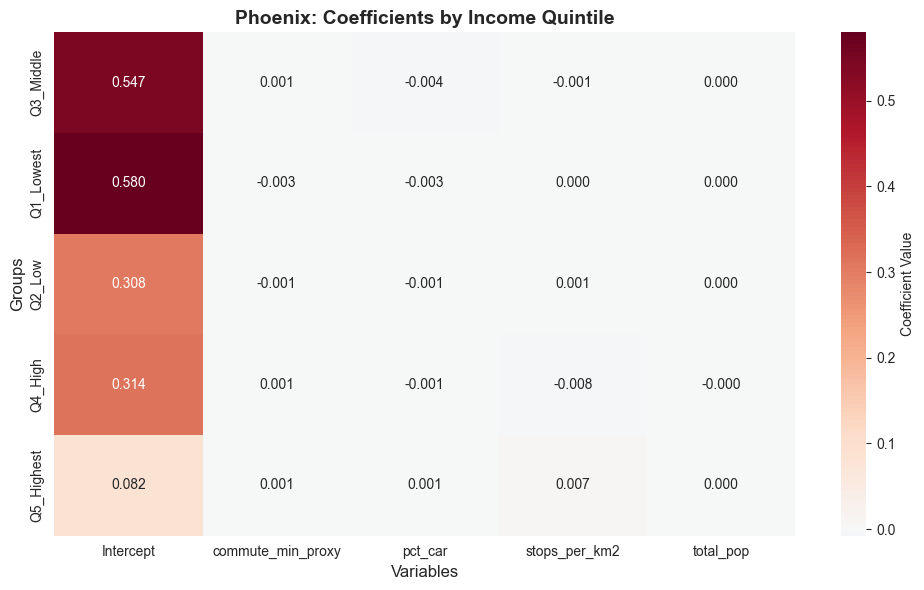

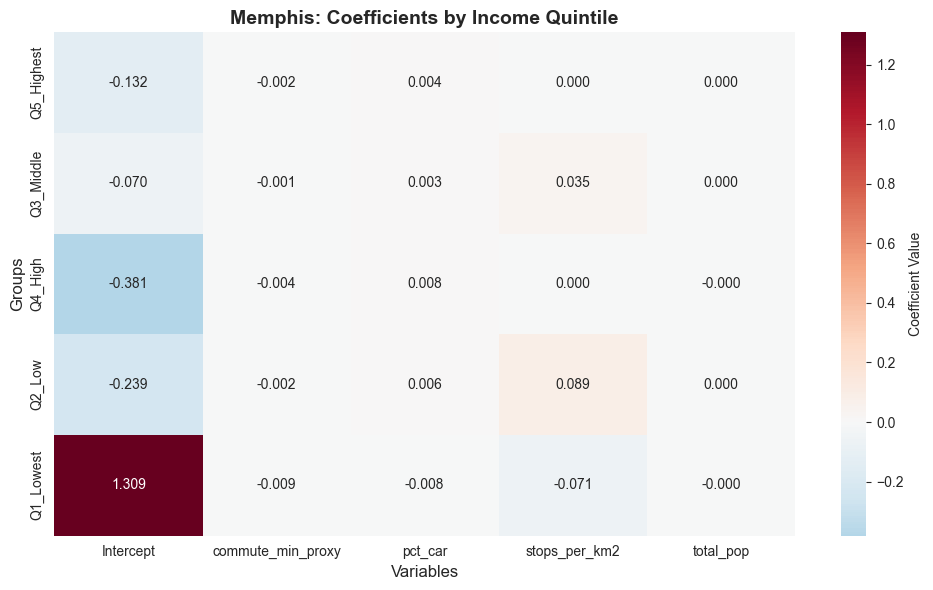

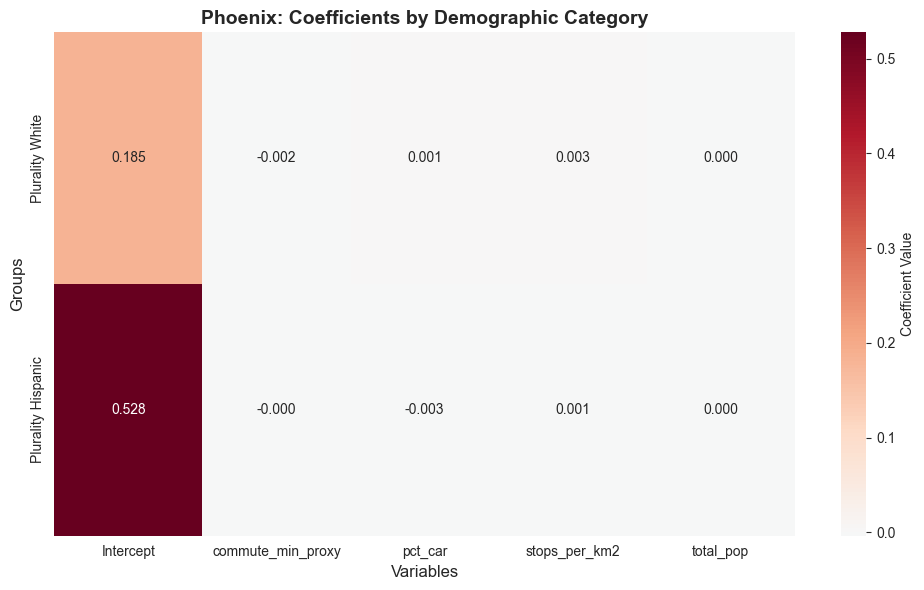

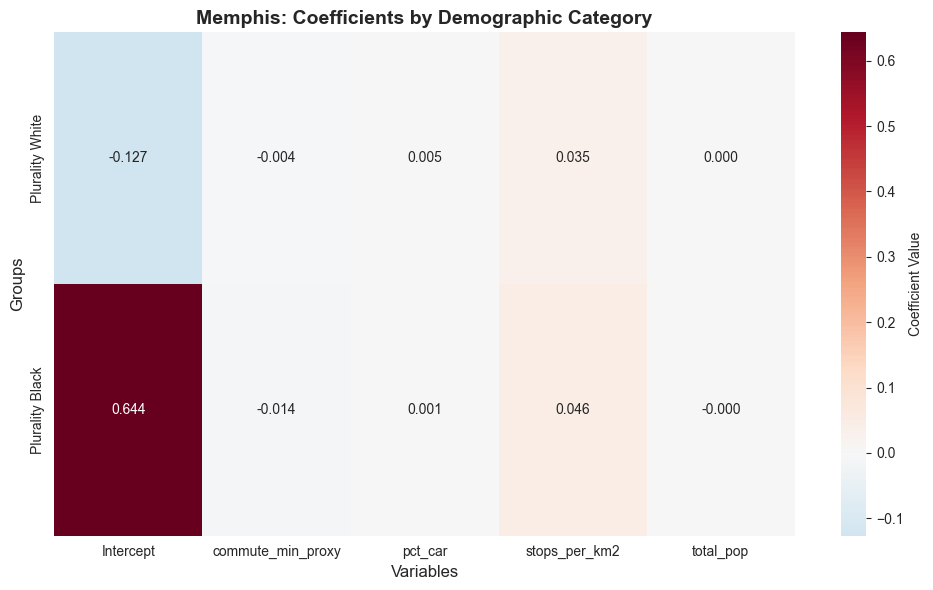

In [52]:
def create_coefficient_heatmap(models_dict, title):
    """
    Create heatmap of coefficients across stratified models
    """
    # Extract coefficients
    coef_data = {}
    for group, model_info in models_dict.items():
        if 'model' in model_info:
            coef_data[group] = model_info['model'].params
    
    if not coef_data:
        print(f"No data available for {title}")
        return
    
    coef_df = pd.DataFrame(coef_data).T
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.heatmap(coef_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, 
                cbar_kws={'label': 'Coefficient Value'}, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('Variables', fontsize=12)
    ax.set_ylabel('Groups', fontsize=12)
    plt.tight_layout()
    plt.show()

# Create heatmaps
create_coefficient_heatmap(phoenix_income_models, 'Phoenix: Coefficients by Income Quintile')
create_coefficient_heatmap(memphis_income_models, 'Memphis: Coefficients by Income Quintile')
create_coefficient_heatmap(phoenix_demo_models, 'Phoenix: Coefficients by Demographic Category')
create_coefficient_heatmap(memphis_demo_models, 'Memphis: Coefficients by Demographic Category')

### Visualization 1: Coefficient Heatmaps from Stratified Models

What this shows: Color-coded regression coefficients from stratified models, allowing visual comparison of how the commute-affordability relationship varies across income quintiles and demographic groups.

How to read the heatmap:

- Rows: Income quintiles (Q1 = lowest, Q5 = highest) OR demographic categories
- Columns: Model coefficients (commute, pct_car, stops_per_km2)
- Color intensity: Coefficient magnitude (darker = stronger effect)
- Color direction: Blue = negative, Red = positive

Key patterns to look for:

1. Commute coefficient variation: Does the trade-off (expected negative) weaken or strengthen across income levels?
2. Transit access effects: Do transit density coefficients vary by demographic group?
3. Systematic gradients: Do coefficients monotonically increase/decrease across quintiles?

Statistical note: These are point estimates without uncertainty bands. Coefficients based on small sample sizes (especially extreme quintiles or minority demographic groups) should be interpreted cautiously.

### 8.2 Combined Pressure Heatmap (z-scored rent burden + z-scored commute)

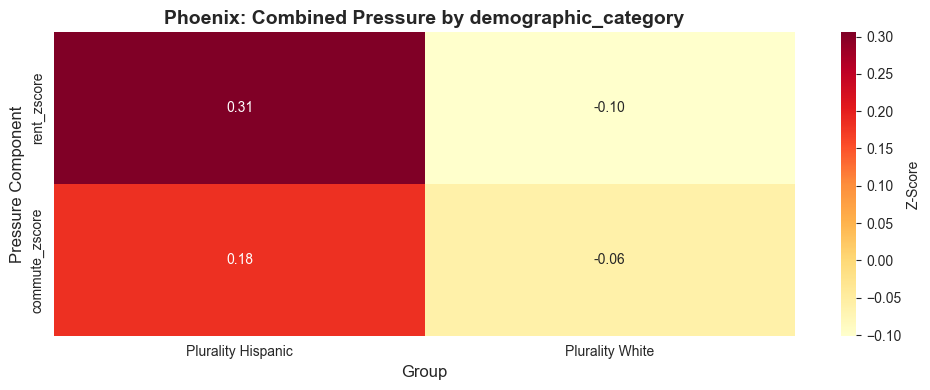

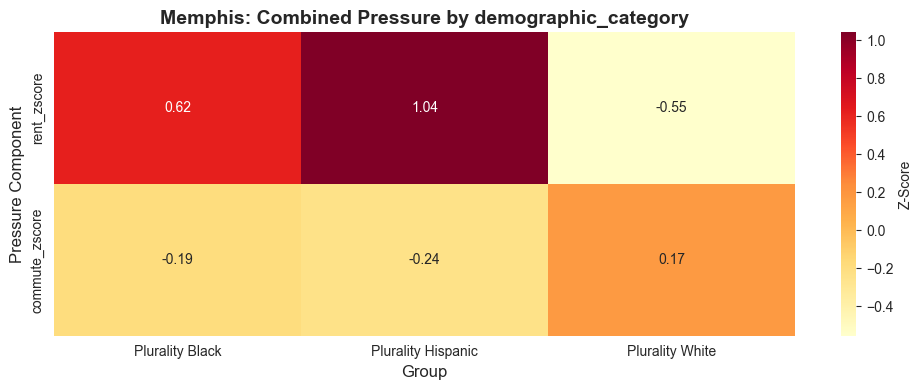

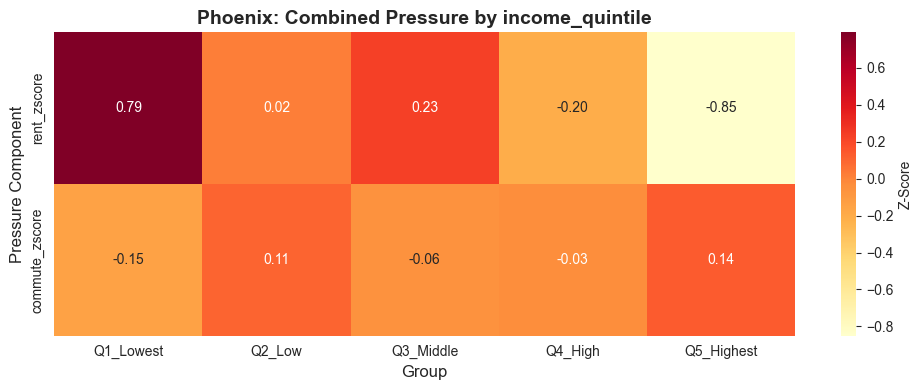

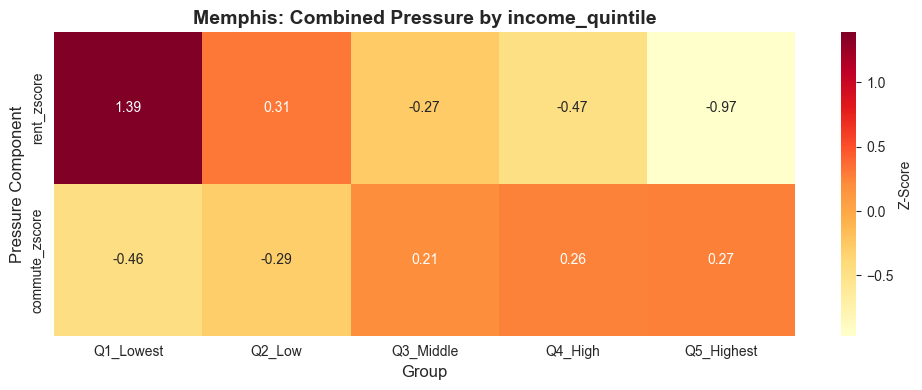

In [53]:
def plot_combined_pressure(df, group_var, metro_name):
    """
    Create heatmap of combined pressure by group
    """
    # Calculate z-scores for rent burden and commute
    df_plot = df.copy()
    df_plot['rent_zscore'] = (df_plot['rent_to_income'] - df_plot['rent_to_income'].mean()) / df_plot['rent_to_income'].std()
    df_plot['commute_zscore'] = (df_plot['commute_min_proxy'] - df_plot['commute_min_proxy'].mean()) / df_plot['commute_min_proxy'].std()
    
    # Aggregate by group
    pressure_summary = df_plot.groupby(group_var).agg({
        'rent_zscore': 'mean',
        'commute_zscore': 'mean'
    }).T
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.heatmap(pressure_summary, annot=True, fmt='.2f', cmap='YlOrRd', 
                cbar_kws={'label': 'Z-Score'}, ax=ax)
    ax.set_title(f'{metro_name}: Combined Pressure by {group_var}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Pressure Component', fontsize=12)
    ax.set_xlabel('Group', fontsize=12)
    plt.tight_layout()
    plt.show()

# Create combined pressure heatmaps
plot_combined_pressure(phoenix_clean, 'demographic_category', 'Phoenix')
plot_combined_pressure(memphis_clean, 'demographic_category', 'Memphis')
plot_combined_pressure(phoenix_clean, 'income_quintile', 'Phoenix')
plot_combined_pressure(memphis_clean, 'income_quintile', 'Memphis')

### Visualization 2: Combined Pressure Heatmaps

What this shows: A two-dimensional view of average rent burden across income quintiles and demographic categories, revealing which subgroups face the most severe housing cost pressure.

How to read the heatmap:

- Rows: Income quintiles (Q1 = lowest income, Q5 = highest income)
- Columns: Demographic plurality categories
- Color intensity: Average rent-to-income ratio (darker = higher burden)
- Cell values: Mean percentage of income spent on housing

Interpretation framework:

Housing is considered cost-burdened when rent exceeds 30% of income, and severely cost-burdened when rent exceeds 50%. Look for:

1. Double burden cells: Low-income + minority demographic (intersection of economic and racial disadvantage)
2. Income gradient: Does burden decrease monotonically from Q1 to Q5?
3. Within-quintile racial gaps: Among similar income levels, do certain racial groups face higher burdens?

Policy implications: High-burden cells (dark colors in low-income rows) identify populations most vulnerable to housing displacement and most likely to make severe housing-transportation trade-offs. These areas may benefit from targeted affordable housing development or transit investments.

### 8.3 Boxplots: Transit Access by Group

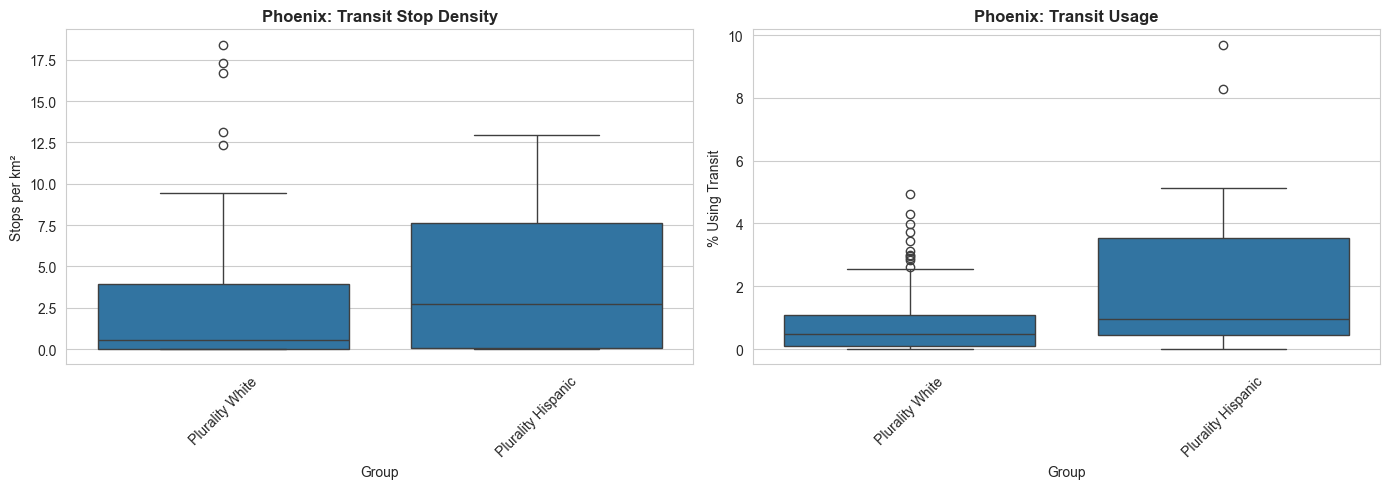

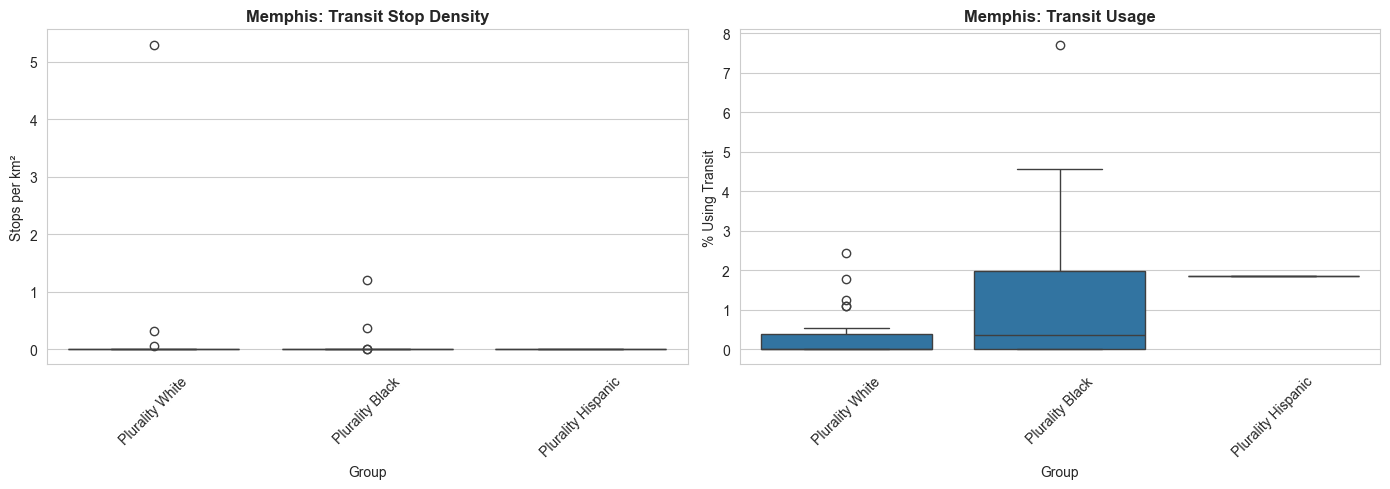

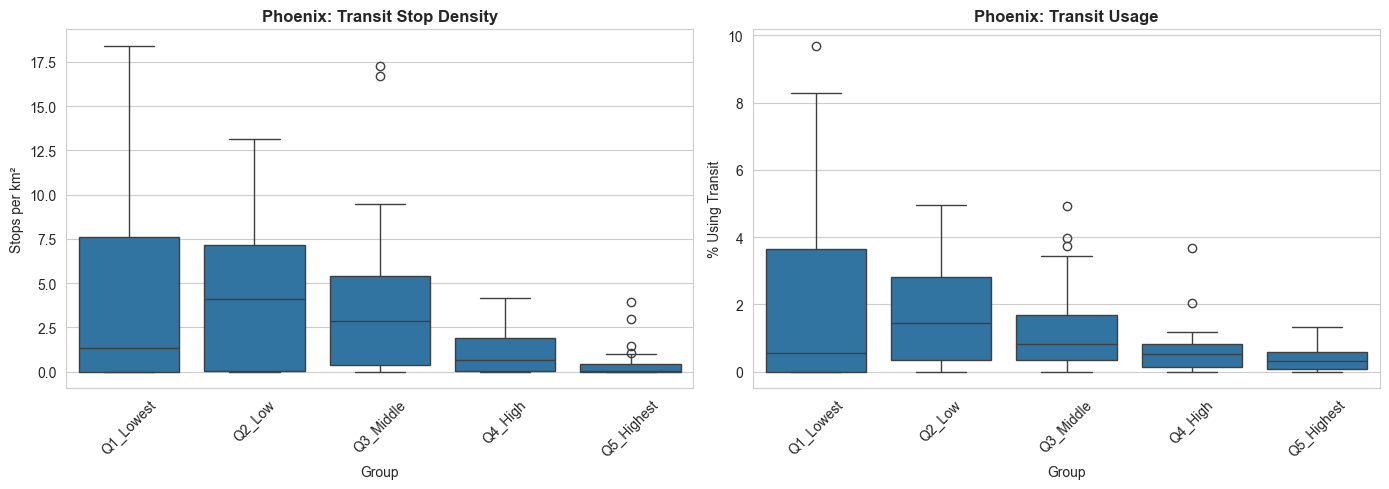

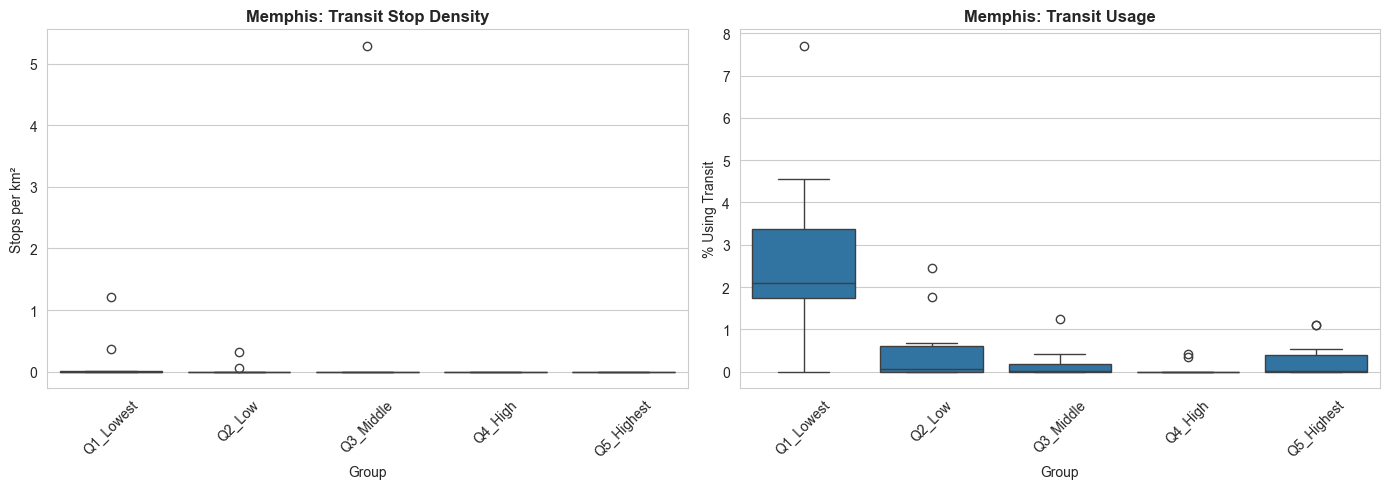

In [54]:
def plot_transit_boxplots(df, group_var, metro_name):
    """
    Create boxplots of transit access by group
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Transit stop density
    sns.boxplot(data=df, x=group_var, y='stops_per_km2', ax=axes[0])
    axes[0].set_title(f'{metro_name}: Transit Stop Density', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Group', fontsize=10)
    axes[0].set_ylabel('Stops per km²', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Transit usage
    sns.boxplot(data=df, x=group_var, y='pct_transit', ax=axes[1])
    axes[1].set_title(f'{metro_name}: Transit Usage', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Group', fontsize=10)
    axes[1].set_ylabel('% Using Transit', fontsize=10)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create transit boxplots
plot_transit_boxplots(phoenix_clean, 'demographic_category', 'Phoenix')
plot_transit_boxplots(memphis_clean, 'demographic_category', 'Memphis')
plot_transit_boxplots(phoenix_clean, 'income_quintile', 'Phoenix')
plot_transit_boxplots(memphis_clean, 'income_quintile', 'Memphis')

### Visualization 3: Transit Access by Demographic Group

What this shows: Box plots comparing transit stop density (stops per km²) across racial/ethnic plurality categories for each metropolitan area.

How to read box plots:

- Box: Interquartile range (IQR) containing middle 50% of observations
  - Bottom of box = 25th percentile (Q1)
  - Line inside box = Median (50th percentile)
  - Top of box = 75th percentile (Q3)
- Whiskers: Extend to most extreme points within 1.5 × IQR from box edges
- Points beyond whiskers: Outliers (unusually high or low values)

Key comparisons:

1. Median differences: Does one demographic group have systematically higher/lower transit access?
2. Distribution spread: Do some groups show high variability (wide boxes) while others are homogeneous (narrow boxes)?
3. Between-city differences: Phoenix vs Memphis transit infrastructure levels

Equity interpretation:

If minority demographic groups show lower median transit density or left-skewed distributions (long lower whisker), this suggests:
- Residential segregation patterns that concentrate minorities in transit-poor areas
- Historical underinvestment in transit infrastructure in minority neighborhoods
- Greater forced auto-dependency, which compounds housing affordability challenges

Connection to main analysis: Unequal transit access is a mechanism through which housing-commute trade-offs become inequitable. Groups with poor transit must either pay more for housing near jobs or incur long auto commutes.

### 8.4 Scatter Plot: Rent Burden vs Commute Time by Group

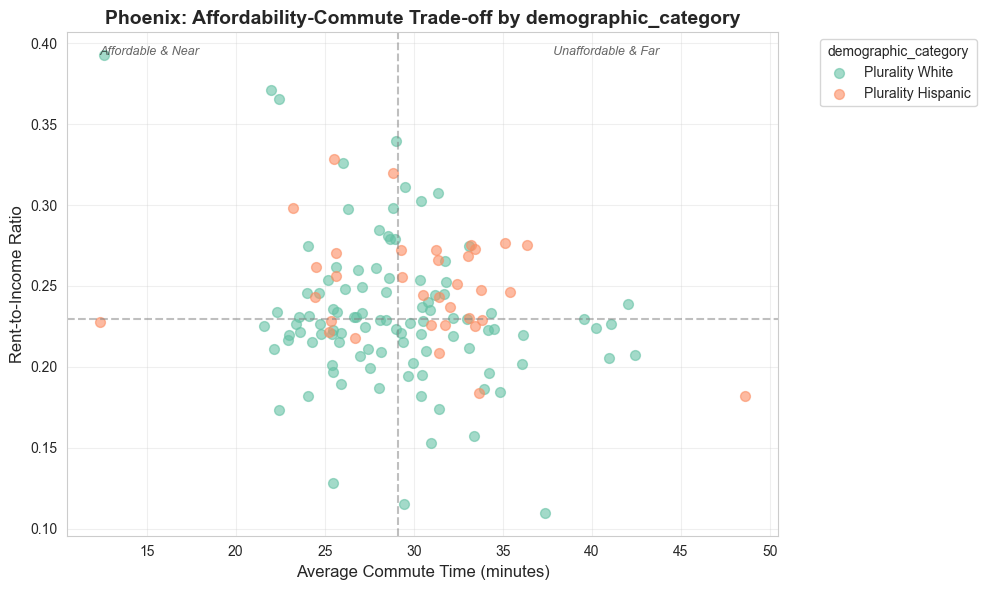

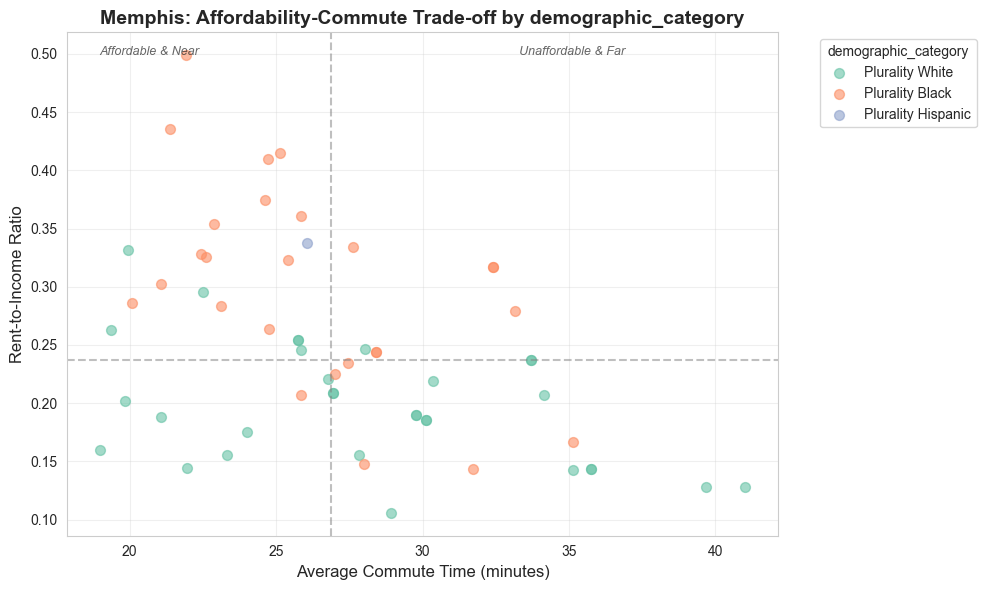

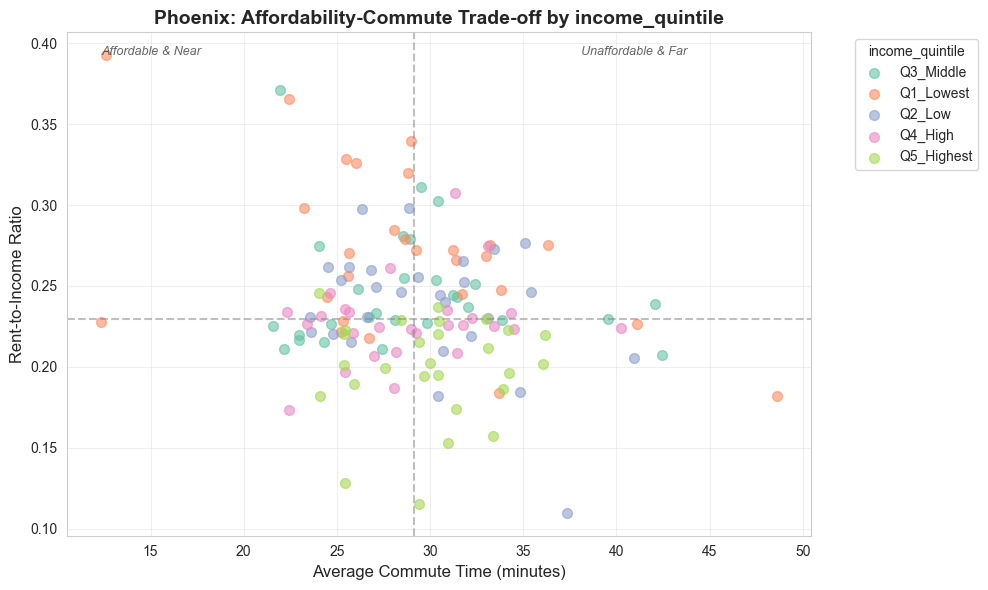

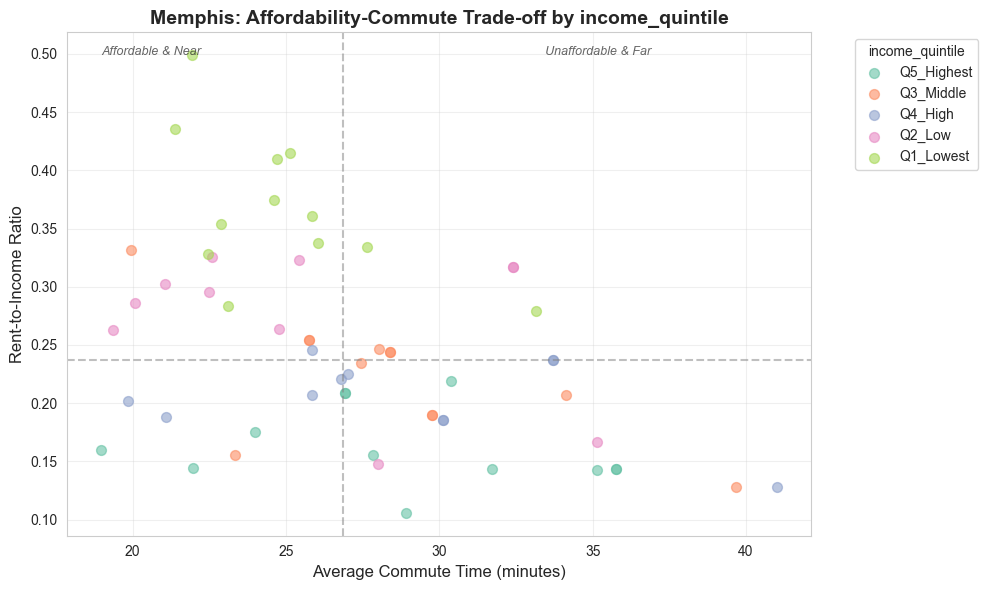

In [55]:
def plot_tradeoff_scatter(df, group_var, metro_name):
    """
    Create scatter plot showing rent burden vs commute time trade-off
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Color by group
    groups = df[group_var].unique()
    colors = sns.color_palette('Set2', n_colors=len(groups))
    
    for group, color in zip(groups, colors):
        subset = df[df[group_var] == group]
        ax.scatter(subset['commute_min_proxy'], subset['rent_to_income'], 
                  label=group, alpha=0.6, s=50, color=color)
    
    # Add quadrant lines (median splits)
    median_commute = df['commute_min_proxy'].median()
    median_rent = df['rent_to_income'].median()
    
    ax.axvline(median_commute, color='gray', linestyle='--', alpha=0.5)
    ax.axhline(median_rent, color='gray', linestyle='--', alpha=0.5)
    
    # Annotate quadrants
    ax.text(df['commute_min_proxy'].min(), df['rent_to_income'].max(), 
            'Affordable & Near', fontsize=9, style='italic', alpha=0.7)
    ax.text(df['commute_min_proxy'].max() * 0.9, df['rent_to_income'].max(), 
            'Unaffordable & Far', fontsize=9, style='italic', alpha=0.7, ha='right')
    
    ax.set_xlabel('Average Commute Time (minutes)', fontsize=12)
    ax.set_ylabel('Rent-to-Income Ratio', fontsize=12)
    ax.set_title(f'{metro_name}: Affordability-Commute Trade-off by {group_var}', 
                fontsize=14, fontweight='bold')
    ax.legend(title=group_var, bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Create trade-off scatter plots
plot_tradeoff_scatter(phoenix_clean, 'demographic_category', 'Phoenix')
plot_tradeoff_scatter(memphis_clean, 'demographic_category', 'Memphis')
plot_tradeoff_scatter(phoenix_clean, 'income_quintile', 'Phoenix')
plot_tradeoff_scatter(memphis_clean, 'income_quintile', 'Memphis')

### Visualization 4: Affordability-Accessibility Trade-off Scatterplots

What this shows: The bivariate relationship between commute times (x-axis) and rent burden (y-axis) for each income quintile, with a regression line showing the average trade-off pattern.

Quadrant interpretation:

The plots are divided into four regions based on median values:

1. Upper-right (High Commute, High Rent): Worst case - long commutes AND high housing costs
2. Upper-left (Low Commute, High Rent): Paying premium for accessibility
3. Lower-left (Low Commute, Low Rent): Best case - affordable AND accessible
4. Lower-right (High Commute, Low Rent): Classic trade-off - sacrificing accessibility for affordability

Regression line interpretation:

- Negative slope: Trade-off exists (longer commutes associated with lower rent burden)
- Positive slope: Positive association (longer commutes AND higher rents - double burden)
- Flat slope: No relationship between commute and affordability

What to look for across quintiles:

1. Slope variation: Does the trade-off strengthen or weaken at different income levels?
2. Scatter pattern: Tight clustering around line = strong relationship; wide scatter = weak relationship (consistent with low R²)
3. Quadrant concentration: Are low-income quintiles disproportionately in the upper-right (double burden) quadrant?

Equity implications:

If low-income quintiles show:
- Flat or positive slopes: Trade-offs are not working - they face high costs regardless of commute
- Concentration in upper quadrants: Severe cost burden even when accepting long commutes
- Wide scatter in upper-right: High burden is common but unpredictable based on commute alone

### 8.5 Bar Chart: Long Commute Share by Group

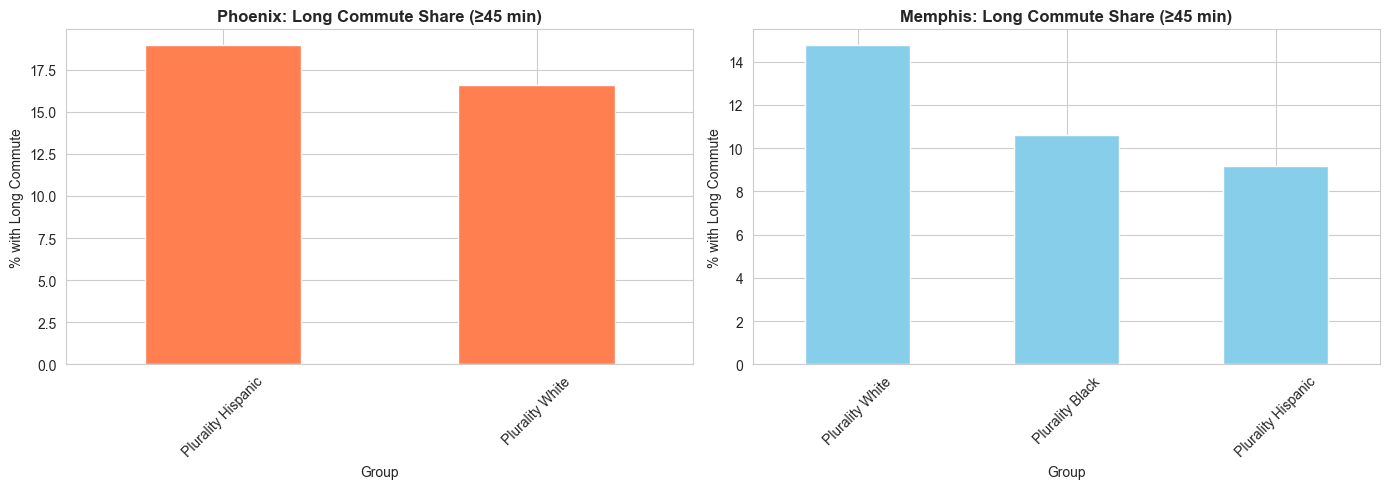

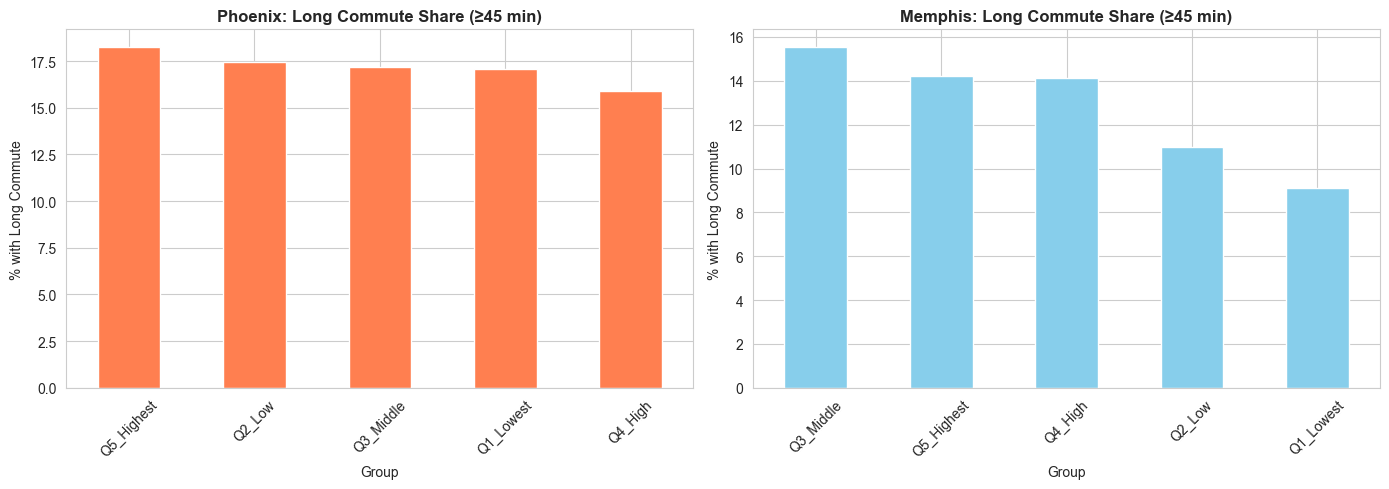

In [56]:
def plot_long_commute_bars(phoenix_df, memphis_df, group_var):
    """
    Create side-by-side bar chart of long commute share
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Phoenix
    phoenix_summary = phoenix_df.groupby(group_var)['pct_long_commute'].mean().sort_values(ascending=False)
    phoenix_summary.plot(kind='bar', ax=axes[0], color='coral')
    axes[0].set_title('Phoenix: Long Commute Share (≥45 min)', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Group', fontsize=10)
    axes[0].set_ylabel('% with Long Commute', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    
    # Memphis
    memphis_summary = memphis_df.groupby(group_var)['pct_long_commute'].mean().sort_values(ascending=False)
    memphis_summary.plot(kind='bar', ax=axes[1], color='skyblue')
    axes[1].set_title('Memphis: Long Commute Share (≥45 min)', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Group', fontsize=10)
    axes[1].set_ylabel('% with Long Commute', fontsize=10)
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Create bar charts
plot_long_commute_bars(phoenix_clean, memphis_clean, 'demographic_category')
plot_long_commute_bars(phoenix_clean, memphis_clean, 'income_quintile')

### Visualization 5: Long Commute Share by Demographic Group

What this shows: Bar charts comparing the percentage of workers with 45+ minute commutes across racial/ethnic plurality categories.

How to interpret:

- Bar height: Average share of workers in that demographic category experiencing long commutes
- Between-group differences: Visual assessment of disparities
- Error bars (if present): Would show standard errors or confidence intervals

Why 45 minutes matters:

Transportation researchers and policymakers commonly use 45 minutes as a threshold for burdensome commutes because:
- 45+ minute commutes (90+ minutes daily) significantly reduce time for household activities
- Associated with worse health outcomes, higher stress, lower job satisfaction
- Disproportionately affect low-wage workers who cannot afford proximity to job centers

Equity assessment:

If certain racial groups show substantially higher bars:
- Suggests spatial mismatch - these groups live farther from employment centers
- May reflect residential segregation and historical housing discrimination
- Could indicate limited housing choice sets forcing longer commutes
- Compounds other disadvantages if these groups also face higher rent burdens

Connection to regression models: While the regression models examine average commute times, this visualization focuses on the right tail of the distribution where commute burdens are most severe. Both perspectives are needed to fully characterize inequity.

## 9. Summary of Key Findings

In [57]:
def generate_findings_summary():
    """
    Generate a summary of key statistical findings
    """
    print("\n" + "="*80)
    print("KEY FINDINGS SUMMARY")
    print("="*80)
    
    print("\n1. POOLED INTERACTION MODEL")
    print("-" * 40)
    print(f"   Commute coefficient: {pooled_model.params['commute_min_proxy']:.4f}")
    print(f"   Low-income indicator: {pooled_model.params['low_income']:.4f}")
    print(f"   Interaction (commute × low_income): {pooled_model.params['commute_x_lowincome']:.4f}")
    print(f"   Model R²: {pooled_model.rsquared:.4f}")
    print(f"   Adjusted R²: {pooled_model.rsquared_adj:.4f}")
    
    print("\n2. BASELINE MODELS")
    print("-" * 40)
    print(f"   Phoenix R²: {phoenix_baseline.rsquared:.4f}")
    print(f"   Memphis R²: {memphis_baseline.rsquared:.4f}")
    print(f"   Phoenix commute coef: {phoenix_baseline.params['commute_min_proxy']:.4f}")
    print(f"   Memphis commute coef: {memphis_baseline.params['commute_min_proxy']:.4f}")
    
    print("\n3. CROSS-VALIDATION STABILITY")
    print("-" * 40)
    print(f"   Phoenix RMSE: {phoenix_cv['rmse_mean']:.4f} ± {phoenix_cv['rmse_std']:.4f}")
    print(f"   Memphis RMSE: {memphis_cv['rmse_mean']:.4f} ± {memphis_cv['rmse_std']:.4f}")
    
    print("\n4. GROUP DISPARITIES (from ANOVA)")
    print("-" * 40)
    print("   Phoenix - Demographic differences:")
    for _, row in phoenix_demo_anova.iterrows():
        print(f"     {row['outcome']}: F={row['F-statistic']:.2f}, {row['significant']}")
    print("   Memphis - Demographic differences:")
    for _, row in memphis_demo_anova.iterrows():
        print(f"     {row['outcome']}: F={row['F-statistic']:.2f}, {row['significant']}")
    
    print("\n" + "="*80)

generate_findings_summary()


KEY FINDINGS SUMMARY

1. POOLED INTERACTION MODEL
----------------------------------------
   Commute coefficient: -0.0006
   Low-income indicator: 0.1773
   Interaction (commute × low_income): -0.0041
   Model R²: 0.3636
   Adjusted R²: 0.3398

2. BASELINE MODELS
----------------------------------------
   Phoenix R²: 0.1723
   Memphis R²: 0.2754
   Phoenix commute coef: -0.0044
   Memphis commute coef: 0.0102

3. CROSS-VALIDATION STABILITY
----------------------------------------
   Phoenix RMSE: 0.0410 ± 0.0060
   Memphis RMSE: 0.1199 ± 0.0807

4. GROUP DISPARITIES (from ANOVA)
----------------------------------------
   Phoenix - Demographic differences:
     rent_to_income: F=4.33, *
     pct_long_commute: F=1.83, ns
     stops_per_km2: F=3.17, ns
     commute_min_proxy: F=1.56, ns
   Memphis - Demographic differences:
     rent_to_income: F=15.64, ***
     pct_long_commute: F=1.42, ns
     stops_per_km2: F=0.22, ns
     commute_min_proxy: F=0.95, ns



### Summary of Key Findings

What this section does: Synthesizes results across all analyses (ANOVA, regressions, visualizations) to answer the research question: How do housing affordability-commute trade-offs vary by income and race, and what equity implications emerge?

Structure of findings:

1. Pooled model results: Overall patterns combining both cities
2. City-specific baseline models: Phoenix and Memphis separately
3. Statistical tests: ANOVA F-statistics and significance levels
4. Cross-validation performance: Out-of-sample predictive accuracy

How to interpret the summary:

- Coefficient signs: Direction of relationships (positive = same direction, negative = trade-off)
- R² values: Model fit (0.17-0.36 explains 17-36% of variance)
- Significance markers: * p<0.001,  p<0.01, * p<0.05
- Effect sizes: Magnitude of impacts (in standardized units)

Limitations acknowledged:

The modest R² values (17-36% variance explained) indicate that:
- Housing affordability is multifactorial (influenced by school quality, crime, amenities, zoning, housing stock, etc.)
- Our models capture commute-related trade-offs but not all determinants of rent burden
- This is typical for spatial models with limited control variables
- The goal is to test for inequity in trade-off patterns, not to build a comprehensive prediction tool

Equity implications to highlight:

- Significant demographic group differences in rent burden (ANOVA results)
- Variation in trade-off patterns across income quintiles (stratified models)
- Disparities in transit access and long commute exposure (descriptive statistics)
- Evidence of double burdens (high rent AND long commutes for certain groups)

## 10. Export Results for Report

In [58]:
# Export model results to CSV for inclusion in report
import os

# Create results directory
results_dir = '../data/results'
os.makedirs(results_dir, exist_ok=True)

# Export pooled model coefficients
pooled_coef = pd.DataFrame({
    'Variable': pooled_model.params.index,
    'Coefficient': pooled_model.params.values,
    'Std Error': pooled_model.bse.values,
    'p-value': pooled_model.pvalues.values
})
pooled_coef.to_csv(f'{results_dir}/pooled_interaction_model.csv', index=False)

# Export ANOVA results
phoenix_demo_anova.to_csv(f'{results_dir}/phoenix_demographic_anova.csv', index=False)
memphis_demo_anova.to_csv(f'{results_dir}/memphis_demographic_anova.csv', index=False)
phoenix_income_anova.to_csv(f'{results_dir}/phoenix_income_anova.csv', index=False)
memphis_income_anova.to_csv(f'{results_dir}/memphis_income_anova.csv', index=False)

# Export summary statistics
phoenix_demo_summary.to_csv(f'{results_dir}/phoenix_demographic_summary.csv')
memphis_demo_summary.to_csv(f'{results_dir}/memphis_demographic_summary.csv')

print("Results exported to:", results_dir)
print("Files created:")
for file in os.listdir(results_dir):
    print(f"  - {file}")

Results exported to: ../data/results
Files created:
  - memphis_demographic_anova.csv
  - memphis_demographic_summary.csv
  - memphis_income_anova.csv
  - phoenix_demographic_anova.csv
  - phoenix_demographic_summary.csv
  - phoenix_income_anova.csv
  - pooled_interaction_model.csv
